In [3]:
!pip install sentence-transformers
!pip install hdbscan
!pip install bertopic

In [4]:
import os
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
from collections import Counter

# Discovery

Before starting I need to understand the file type of the dataset, by listing all file in the directory and getting all file extension I can easily know the file type, therefore dealing with them accordingly.

In [5]:
# - os.listdir list all file in the directory
# - os.path.splittext divide the filename into filename and extension, it returns a tuple and 
# the second element is the extension
# - set returns the unique file extensions.
xml_list_files = os.listdir('/kaggle/input/nsf-research-awards-abstracts')
set([os.path.splitext(file)[1] for file in xml_list_files])

{'.xml'}

Since all files are XML, I'll be using ElemntTree from python that parse the file into a tree format to process and analyze it correctly.

The XML content starts at `rootTag` that nestes `Award`. It contains lot of information like the title, agency, award expiration date, award amount, abstract, and much more.

Since all this information not necessarly to classify all awards by topic, I'll be focusing in only three fields:

1. `AwardTitle`: This will serve as a summary on the abstract. *Hypothesis*: Provides context about the topic.
2. `Division`: The Division name could provide more information of the topic. *Hypothesis*: Each division will focus on knowledge areas.
3. `AbstractNarration`: The abstract of the award, this has the more useful information to clusterize.

In [6]:
tree = ET.parse('/kaggle/input/nsf-research-awards-abstracts/2000009.xml')
root = tree.getroot()
award = root.find("Award")
for child in award:
    print(child.tag)

AwardTitle
AGENCY
AwardEffectiveDate
AwardExpirationDate
AwardTotalIntnAmount
AwardAmount
AwardInstrument
Organization
ProgramOfficer
AbstractNarration
MinAmdLetterDate
MaxAmdLetterDate
ARRAAmount
TRAN_TYPE
CFDA_NUM
NSF_PAR_USE_FLAG
FUND_AGCY_CODE
AWDG_AGCY_CODE
AwardID
Investigator
Institution
Performance_Institution
ProgramElement
ProgramReference
ProgramReference
ProgramReference
Appropriation
Fund
FUND_OBLG
POR


# Data Ingestion

The dataset contains more than 13 thousand documents. To optimize the consumptions I'll be using iterators. My first thought was to use recursive functions; however, python has a limitation in the maximum recursion depth.

On the other hand, iterators are lazy evaluators, being helpful to read a lot of files only when needed.

To be more memory efficient, first I'll split the `xml_list_files` into training and test set. After that, I'll create batches on training data, so the consumptions will be faster.

In [7]:
# Recursive function. Not used because of maximum recursion depth
# def parsing_docs(doc_list):
#     docs = []
#     directory = '/kaggle/input/nsf-research-awards-abstracts/'
    
#     # recursive case
#     if len(doc_list) > 0:
#         doc = doc_list[0]
#         full_dir = os.path.join(directory, doc)
#         award_title = ET.parse(full_dir).find("./Award/AwardTitle")
#         organization = ET.parse(full_dir).find("./Award/Organization")
#         abstract_narration = ET.parse(full_dir).find("./Award/AbstractNarration")
#         docs.append((award_title, organization, abstract_narration))
#         docs.extend(parsing_docs(doc_list[1:]))
        
#     return docs

In [8]:
from sklearn.model_selection import train_test_split

# Split the list into train and test
train_list, test_list = train_test_split(xml_list_files, test_size=0.33, shuffle=True)

In [9]:
class CreateTrainingBatches:
    """
    This class is used to yield an iterator of fixed size. Size is calculated during initialization and used the
    training size and the number of batches to produce the output. Number of batches is configurable
    """
    
    def __init__(self, train_set, num_batches=4):
        self.__train_set = train_set
        # Define the batch size and the number of batches
        self.__num_batches = num_batches
        self.__train_size = len(self.__train_set)
        self.__batch_size = round(self.__train_size / self.__num_batches)
        
    def create_batches(self):
        # Yield an iterator
        for i in range(self.__num_batches):
            yield self.__train_set[i*self.__batch_size:(i+1)*self.__batch_size]

In [10]:
class XMLProcessor:
    """
    Class dedicated to process XML, the input must be an iterator, so the processing is the most memory efficient as possible.
    The process method will read the input iterator each time is called, when the iterator is empty, it will print a message.
    """
    
    def __init__(self, batches: iter):
        self.__batches = batches
    
    def filter_xml_element(self, file_path):
        """
        Filter the tasg of interest. This function can be modified to get any other tag of interest.
        However, changing this implies to modify the convert_to_dataframe function and the get_text_elements
        in case the new tag needs further processing.
        """
        tags_of_interest = {'AwardTitle','Organization','AbstractNarration','AwardID'}
        context = ET.iterparse(file_path)
        return filter(lambda xml: xml[1].tag in tags_of_interest, context)

    def process_files(self, xml_file):
        """
        Maps the filtering functions to each xml.
        """
        return map(lambda file: self.filter_xml_element(file), xml_file)

    def prepare_files(self, lst):
        """
        The input list is full of names only. This function concat the 
        XML directory to the filename.
        """
        xml_dir = '/kaggle/input/nsf-research-awards-abstracts'
        return map(lambda file: os.path.join(xml_dir, file), lst)

    def get_text_elements(self, xml):
        """
        It get the text data from the filtered tags. Only organization recieves a particular
        case since the function looks for Division - LongName.
        """
        if xml[1].tag == 'Organization':
            # Search for Division tag inside Organization
            division = [elem for elem in xml[1] if elem.tag == 'Division']
            # Inside Division, search to LongName (the name of the division)
            long_name = [elem for elem in division[0] if elem.tag == 'LongName']
            return long_name[0].text
        else:
            return xml[1].text

    def get_data_from_generator(self, data):
        """
        It maps the get_text_element to generate a list of text data
        """
        return [map(lambda x: self.get_text_elements(x), elem) for elem in data]

    def convert_to_dataframe(self, text_data):
        """
        Conver the input text in list format into a dataframe for further processing
        """
        return pd.DataFrame(
            data=[list(data) for data in text_data],
            columns=['AwardTitle','Division','AbstractNarration','AwardID']
        )

    def process(self):
        """
        Main function of the class
        """
        try:
            lst = next(self.__batches)

            xml_files = self.prepare_files(lst)
            xml_data = self.process_files(xml_files)
            xml_text_data = self.get_data_from_generator(xml_data)
            return self.convert_to_dataframe(xml_text_data).assign(file = lst)
        except StopIteration:
            print("Iterator is empty")

In [11]:
batch_gen = CreateTrainingBatches(train_list)
it = batch_gen.create_batches()

xml_pr = XMLProcessor(it)
# This method will generate a new dataframe each time is called.
# This way I can explore a sample of 2 thousand records and, when needed, call the next 2 thounsand until the iterator is empty
# When the last one occurs, it will print a message.
df1 = xml_pr.process()

In [12]:
def read_single_xml(file):
    xml_dir = '/kaggle/input/nsf-research-awards-abstracts'
    filename = os.path.join(xml_dir, file)
    return ET.parse(filename)

# EDA

To begin, I start with a sample of the training set doing the following steps:

1. **Remove empty records:** Since we are trying to clusterize all the XML, it is necessary to understand the context of the data including the empty records. This will help me understand if there are files that required special treatment and decided whether the effort is worthy. In case their emptiness is because the XML file comes in that format or the effort is not worthy because of the impact into the data, I will drop them instead.
2. **Convert all text to lowercase:** Doing NLP requirest to standarize incoming text. To do so, the first step is lowercast everything.
3. **Remove punctuation:** Dots, commas, semicolon, etc. doesn't provide any relevant information to context of the string.
4. **Define and remove stopwords:** These are repetitive words like `the`, `is`, `are`, etc. Since they are mayority in any text, they will introduce noise into the model when trying to identify patterns.

In [13]:
# I didn't expect to have empty values in AbstractNarration. 
# They are not a lot, I can assume that the other training batches have more or less the same number of empty AbstractNarration columns (they are shuffled)
# Just to confirm that I'm not missing something, I will get one of this files and reviwed by hand to ensure there are not exceptions.
df1.isna().sum()

AwardTitle            0
Division              0
AbstractNarration    21
AwardID               0
file                  0
dtype: int64

In [14]:
df1.query("AbstractNarration.isna()")

,AwardTitle,Division,AbstractNarration,AwardID,file
45,Intergovernmental Personnel Agreement,"Div Of Electrical, Commun & Cyber Sys",None,2051742,2051742.xml
143,US Army Cold Regions Research and Engineering ...,Office of Polar Programs (OPP),None,2030136,2030136.xml
147,Intergovernmental Personnel Act - IPA Assignment,Divn Of Social and Economic Sciences,None,2040107,2040107.xml
198,Intergovernmental Personnel Agreement,Division Of Chemistry,None,2052862,2052862.xml
229,HR LoB,Division Of Human Resource Management,None,2039835,2039835.xml
325,Intergovernmental Personnel Act (Mobility assi...,Division Of Undergraduate Education,None,2037967,2037967.xml
470,IAA for special issuance passports.,Division Of Administrative Services,None,2039237,2039237.xml
555,Federal Investigations Reimbursable Billing,Division Of Administrative Services,None,2001271,2001271.xml
816,FLETC Training,Office Of Inspector General,None,2002944,2002944.xml
1246,IPA for Subrata Acharya,OIA-Office of Integrative Activities,None,2049879,2049879.xml


In [15]:
# Seems that they are just empty. I will drop all empty records on AbstractNarration.
for child in read_single_xml("2051285.xml").find('./Award/AbstractNarration'):
    print(child.tag, child.attrib)
    
for child in read_single_xml("2026426.xml").find('./Award/AbstractNarration'):
    print(child.tag, child.attrib)

In [16]:
df1.dropna(subset=["AbstractNarration"], inplace=True)

In [17]:
import nltk
import subprocess

# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

[nltk_data] Downloading package wordnet to /kaggle/working/...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /kaggle/working/corpora/wordnet.zip


replace /kaggle/working/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


In [18]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))

## Text representation

From this point, I'll be introducing a transformer to convert all sentences into vectors. However, each transformer has capabilities that works on particular scenarios.

As an example, the `all-MiniLM-L6-v2` process sequences that don't exceed 256 characters. That is that the model only considered the first 256 characters and build the vectors based on that, affecting the quality and consistency of the embeddings.

The first metric that I'll be looking at is the number of tokens or sequence length. This is important to be considered before picking a model.

<Axes: ylabel='Frequency'>

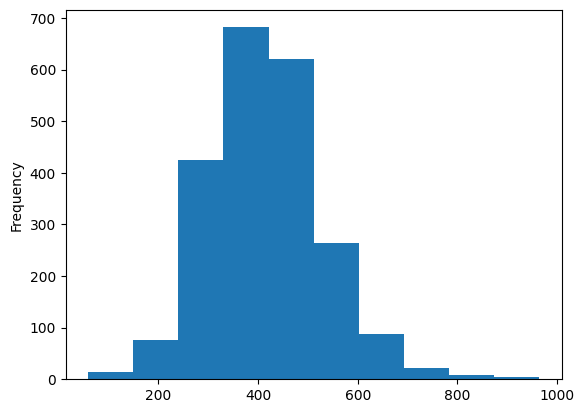

In [19]:
# The histogram shows that about 70% of the data has between 300 and 500 tokens
# a model that can manage more than 200 tokens will work for this case
df1.AbstractNarration.str.split().str.len().plot.hist()

In [20]:
# To reduce the number of tokens on sentences I will remove special characters and stopwords
stop_words = set(stopwords.words("english"))
df1['AbstractNarration_clean'] = df1['AbstractNarration'].str.replace("[^a-zA-Z0-9]"," ", regex=True)
df1['AbstractNarration_clean'] = df1['AbstractNarration_clean'].map(lambda sentence: " ".join([word for word in sentence.lower().split() if word not in stop_words]))

### Increasing stop words list

I'd removed the most common stop words in english, but there could be more particular words that may affect the sentence representation. Also, this will reduce the sentence lenght and improve the model sentence representation.

In [21]:
# I will be removing the 10 most common words in all documents.
from collections import Counter

most_common_10 = Counter(" ".join(df1.AbstractNarration_clean.tolist()).split()).most_common(10)
most_common_10_list = [word for word, _ in most_common_10]

In [22]:
df1["AbstractNarration_clean"] = df1.AbstractNarration_clean.map(lambda sentence: " ".join([word for word in sentence.split() if word not in most_common_10_list]))

<Axes: ylabel='Frequency'>

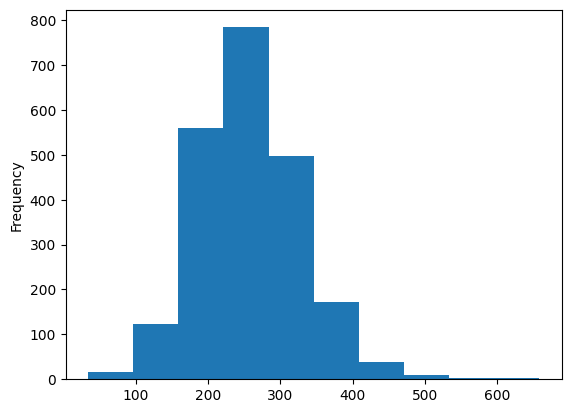

In [23]:
# Now the sentence length has been reduced between 150 and 350 tokens in average
df1.AbstractNarration_clean.str.split().str.len().plot.hist()

# Topic Modeling

## Topic Modeling BERTopic

BERTopic is a technique leverages a transformer and c-TF-IDF to create dense clusters. The technique basically involves multiples algorithms applied to the input in the following order:

1. Embbedings: Converts words into vectors
2. Dimensionality Reduction: Reduces the vector space representation dimensionality
3. Clustering: A clustering algorithm that groups similar embbedings to extract topics. Tipically HDBSCAN for its capability to capture structures with different densities.
4. Tokenizer: Create the topic representation, usually with a vectorizer algorithm.
5. Weighting scheme: To get the most accurate result for each topic, the techinique uses a variation of TF-IDF, adjusting the clustering by evaluating clusters against all documents.
6. Representation tunning: Using a LLM or similars, it's possible to present topics into more understandable representation.

This is a brief of the all BERTopic capabilities, for further reference here is the [link](https://maartengr.github.io/BERTopic/algorithm/algorithm.html)

In [24]:
from bertopic import BERTopic

topic_model = BERTopic()
topics, probs = topic_model.fit_transform(df1.AbstractNarration_clean.tolist())

In [25]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,443,-1_education_science_engineering_new,"[education, science, engineering, new, learnin...",[division learning formal informal settings di...
1,0,135,0_cybersecurity_security_software_computing,"[cybersecurity, security, software, computing,...",[recent trend migrating computation centralize...
2,1,98,1_cell_cells_proteins_protein,"[cell, cells, proteins, protein, cellular, tis...",[different cell types make body skin cells blo...
3,2,87,2_ocean_sea_ice_climate,"[ocean, sea, ice, climate, carbon, marine, glo...",[management implementation 60 day cruise amund...
4,3,75,3_robots_control_robot_human,"[robots, control, robot, human, systems, learn...",[introduces learner helper robot pairs enable ...
5,4,71,4_information_decision_social_policy,"[information, decision, social, policy, leader...",[individuals leadership roles represent large ...
6,5,65,5_sars_virus_cov_viral,"[sars, virus, cov, viral, covid, 19, coronavir...",[covid 19 pandemic caused sars cov 2 virus vir...
7,6,65,6_theory_geometry_algebraic_spaces,"[theory, geometry, algebraic, spaces, geometri...",[fundamental question contemporary number theo...
8,7,63,7_business_phase_patients_sleep,"[business, phase, patients, sleep, sbir, small...",[broader impact commercial potential small bus...
9,8,60,8_species_plant_diversity_fellow,"[species, plant, diversity, fellow, plants, ev...",[biology integration institute use tools remot...


### Evaluating topics

A measure used to evaluate how well the topics are constructed is by using the topic coherence. The measure uses a the coherence concept that is based on cooperation characteristic by knowing how well a topic is supported by a text set.

The calculation is based on a pipeline. 

1. First, the model creates pairs of word subsets;
2. then, a probability calculation is done by having the probability of a word and the occurance of w1 and w2; 
3. after that a confirmation measure take place where the model quantifies the relation between subsets based on the probability calculation. There are two types of confirmation measure, the direct confirmation by using words subsets and their probabilities; and the indirect confirmation, it takes the words subsets and creates a direct confirmation metric building two vectors to calculate a similarity measure on those two vectors.
4. Finally, it takes all values calculated from the previous steps and aggregates them into a single value. This aggregation could be a mean (arithmetic or geometric), median or whatever other aggregation.

> I describe it at high-level, the reference I use to perform the metric is on this [page](https://towardsdatascience.com/understanding-topic-coherence-measures-4aa41339634c)

In [26]:
df1['bertopic'] = topics
topics_words = []
for topic in np.unique(topics):
    word_abstract = Counter(' '.join(df1.query('bertopic == @topic')['AbstractNarration_clean']).split())
    most_common = word_abstract.most_common(10)
    topics_words.append([word for word, _ in most_common])

In [27]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary

texts = df1.AbstractNarration_clean.str.split().tolist()
word2id = Dictionary(texts)

# Coherence model
cm = CoherenceModel(topics=topics_words, 
                    texts=texts,
                    coherence='c_v',  
                    dictionary=word2id)

coherence_per_topic = cm.get_coherence_per_topic()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


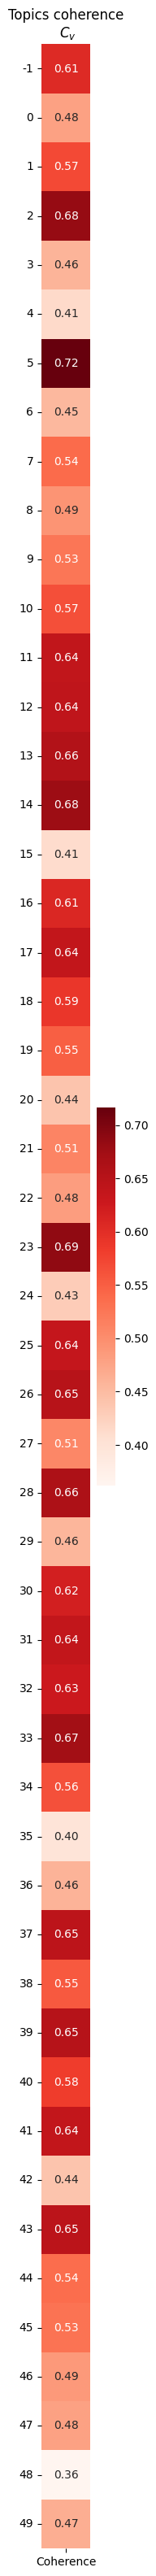

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# topics_str = [ '\n '.join(t) for t in topics_words ]
data_topic_score = pd.DataFrame( data=zip(np.unique(topics), coherence_per_topic), columns=['Topic', 'Coherence'] )
data_topic_score = data_topic_score.set_index('Topic')

fig, ax = plt.subplots( figsize=(2,40) )
ax.set_title("Topics coherence\n $C_v$")
sns.heatmap(data=data_topic_score, annot=True, square=True,
            cmap='Reds', fmt='.2f',
            linecolor='black', ax=ax )
plt.yticks( rotation=0 )
ax.set_xlabel('')
ax.set_ylabel('')
fig.show()


## Topic Modeling embeddings + hdbscan

Using the all-MiniLM-L6-v2 model to calculate the embeddings, I'll start by performing a topic modeling task to identify the topic of all documents.

This will be useful further to create a document retrieval process

In [29]:
from sentence_transformers import SentenceTransformer

# all-MiniLM-L6-v2 can handle up to 256 tokens
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(df1.AbstractNarration_clean.tolist())
print(embeddings.shape)

Batches:   0%|          | 0/69 [00:00<?, ?it/s]

(2207, 384)


In [30]:
import hdbscan

cluster = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1)
topics = cluster.fit_predict(embeddings)

df1['hdbscan_topics'] = topics
topics, counts = np.unique(topics, return_counts=True)

for topic, count in zip(topics, counts):
    print(topic, count)

-1 190
0 5
1 21
2 1985
3 6


### Evaluating topics

A measure used to evaluate how well the topics are constructed is by using the topic coherence. The measure uses a the coherence concept that is based on cooperation characteristic by knowing how well a topic is supported by a text set.

The calculation is based on a pipeline. 

1. First, the model creates pairs of word subsets;
2. then, a probability calculation is done by having the probability of a word and the occurance of w1 and w2; 
3. after that a confirmation measure take place where the model quantifies the relation between subsets based on the probability calculation. There are two types of confirmation measure, the direct confirmation by using words subsets and their probabilities; and the indirect confirmation, it takes the words subsets and creates a direct confirmation metric building two vectors to calculate a similarity measure on those two vectors.
4. Finally, it takes all values calculated from the previous steps and aggregates them into a single value. This aggregation could be a mean (arithmetic or geometric), median or whatever other aggregation.

> I describe it at high-level, the reference I use to perform the metric is on this [page](https://towardsdatascience.com/understanding-topic-coherence-measures-4aa41339634c)

In [31]:
topics_words = []
for topic in np.unique(topics):
    word_abstract = Counter(' '.join(df1.query('hdbscan_topics == @topic')['AbstractNarration_clean']).split())
    most_common = word_abstract.most_common(10)
    topics_words.append([word for word, _ in most_common])

In [32]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary

texts = df1.AbstractNarration_clean.str.split().tolist()
word2id = Dictionary(texts)

# Coherence model
cm = CoherenceModel(topics=topics_words, 
                    texts=texts,
                    coherence='c_v',  
                    dictionary=word2id)

coherence_per_topic = cm.get_coherence_per_topic()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


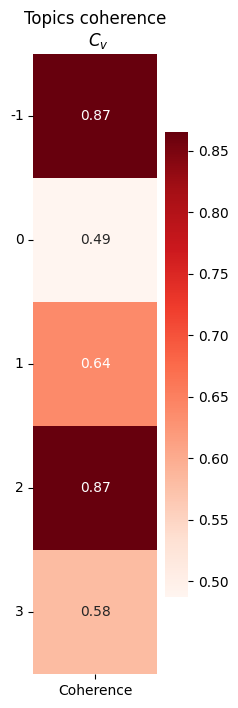

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# topics_str = [ '\n '.join(t) for t in topics_words ]
data_topic_score = pd.DataFrame( data=zip(np.unique(topics), coherence_per_topic), columns=['Topic', 'Coherence'] )
data_topic_score = data_topic_score.set_index('Topic')

fig, ax = plt.subplots( figsize=(2,40) )
ax.set_title("Topics coherence\n $C_v$")
sns.heatmap(data=data_topic_score, annot=True, square=True,
            cmap='Reds', fmt='.2f',
            linecolor='black', ax=ax )
plt.yticks( rotation=0 )
ax.set_xlabel('')
ax.set_ylabel('')
fig.show()

This the previous plot, I can see what topics are well constructed and what aren't. Using this information I could work on improving my topics by doing a more extensive text preprocessing and post-processing techniques.

> For now, I will left it as is and continue with the following task.

Now, I will take the first 5 topics and uses one of them to retrieve the related documents.

In [34]:
for topic in np.unique(topics)[:5]:
    print(topic)
    word_abstract = Counter(' '.join(df1.query('hdbscan_topics == @topic')['AbstractNarration_clean']).split())
    print(word_abstract.most_common(10))

-1
[('broader', 229), ('new', 195), ('evaluation', 194), ('foundation', 194), ('intellectual', 190), ('review', 190), ('criteria', 189), ('reflects', 187), ('mission', 187), ('merit', 186)]
0
[('mathematical', 10), ('sciences', 10), ('fellowships', 10), ('host', 10), ('institution', 10), ('sponsoring', 10), ('scientist', 10), ('fellowship', 10), ('made', 5), ('part', 5)]
1
[('spectrum', 127), ('wireless', 119), ('systems', 65), ('radio', 59), ('passive', 45), ('energy', 41), ('active', 40), ('new', 38), ('interference', 35), ('network', 34)]
2
[('new', 2412), ('broader', 2387), ('evaluation', 2099), ('foundation', 2092), ('intellectual', 2018), ('mission', 2012), ('criteria', 1978), ('merit', 1972), ('review', 1971), ('reflects', 1956)]
3
[('leadership', 47), ('nonwork', 22), ('leaders', 21), ('individuals', 16), ('group', 16), ('work', 14), ('experiences', 13), ('organizations', 12), ('economic', 11), ('use', 11)]


# Document Retrieval

Knowing how all documents are organized, I can create a model that retrieve documents based on a query. This is also done using a transformer based on semantic search.

Now, there are two types of semantic search:

1. Symmetric semantic search: It searches for entries with same lenght and same amount of content, for example, you ask "How to learn python online?" expecting to retrieve documents with similar questions like "How to learn python on the web?".
2. Asymmetric semantic search: It uses short queries like a question or keywords and you expect to retrieve paragraphs that answer that query. If you ask "What is python?" you expected to find a paragraph saying "Python is an interpreter, high-level and general-purpose...".

Since I already have an image on the topics for all documents. Now, I'll be evaluating these clusters to determine the construction and create a summary on topics to get a propper topic modeling.

For this task the models that are more suitable are the based on asymmetric semantic search, here I will be testing two different models the `multi-qa-mpnet-base-dot-v1` and `msmarco-bert-base-dot-v5`.

The main difference between both of them is the training data. The first one was trained with 215M question-answer pairs from StackExchange, Yahoo Answers, Google and Bing. While the second one was trained with 500k queries from Bing. Also, the first one uses a `[CLS]` pooling method, while the second one uses mean pooling.

## Multi QA MPNET

Here I'm testing a model based on semantic search using dot product for similarity score. It maps documents and query into a 768 dimensional dense vector. It doesn't return normalized embeddings and uses `[CLS]` pooling as pooling method.

> NOTE: A pooling method is a method used by the model to represent a phrase embedding. There are three main types of pooling methods:
> 1. Mean Pooling: Means the embeddings of all tokens in a sentence.
> 2. Max Pooling: Gets the maximum value out of all dimensions for all embeddings.
> 3. `[CLS]` Pooling: Uses the `[CLS]` embedding token that is usually at the begining of the sentence. It generally contains the sentence's global context.

In [40]:
# gensim
dir(topic_model)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_auto_reduce_topics',
 '_c_tf_idf',
 '_cluster_embeddings',
 '_combine_zeroshot_topics',
 '_create_topic_vectors',
 '_extract_embeddings',
 '_extract_representative_docs',
 '_extract_topics',
 '_extract_words_per_topic',
 '_get_param_names',
 '_guided_topic_modeling',
 '_images_to_text',
 '_is_zeroshot',
 '_map_predictions',
 '_map_probabilities',
 '_merged_topics',
 '_outliers',
 '_preprocess_text',
 '_reduce_dimensionality',
 '_reduce_to_n_topics',
 '_reduce_topics',
 '_save_representative_docs',
 '_sort_mappings_by_frequency',
 '_top_n_idx_sparse',
 '_top_n_values_sparse',
 '_topic_id_to_zeroshot_topic_idx',
 '_update

In [35]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("multi-qa-mpnet-base-dot-v1")

document_embeddings = model.encode(df1.AbstractNarration_clean.tolist())

query = "graduate stem" # These are keywords from topic 3
query_embedding = model.encode(query)

Batches:   0%|          | 0/69 [00:00<?, ?it/s]

KeyboardInterrupt: 

When encoded, I can search for semantic similarities between the query and the documents. Using `semantic_search` method from `sentence_transformers.utils` I retrieved the top 5 documents with the most similarity to the query.

When looking at the top 5 documents labeled using the HDBSCAN topic modeling. I can see that 4 out of 5 (80%) of the documents retrived by the model share the same topic.

In [ ]:
from sentence_transformers.util import semantic_search

search = semantic_search(query_embedding, document_embeddings, top_k=5)
documents = [item['corpus_id'] for item in search[0]]
search

In [ ]:
df1.iloc[documents]

## MSMARCO BERT

Unlike `multi-qa-mpnet` model, this has a max sequence lenght of 512 tokens and uses mean pooling as pooling method.

There are some advantages and disadvantages of using one pooling method or another.

Mean pooling captures the general context of the sentence and it is well balanced on the representation. On the other hand, it doesn't recognize between important and less important tokens.

`[CLS]` pooling is computational efficient since it doesn't make any operation, it only takes the `[CLS]` token. However, this method can be used only on models that calculates the `[CLS]` token.

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("msmarco-bert-base-dot-v5")

document_embeddings = model.encode(df1.AbstractNarration_clean.tolist())

query = "graduate stem"
query_embedding = model.encode(query)

Compared to the other model. It shows more consistent results, 5 our of 5 (100%) documents retrieved matches the same cluster and the similarity score is high enoght to be confident that the results are really close to the query.

> If I compared with the previous one, the scores are bellow 0.6. This shows that the previous model is not confident enough to retrieve documents with high similarity to the query or I need to provide another kind of preprocessing or post-processing technique.

In [ ]:
from sentence_transformers.util import semantic_search

search = semantic_search(query_embedding, document_embeddings, top_k=5)
documents = [item['corpus_id'] for item in search[0]]
search

In [ ]:
df1.iloc[documents]

# Conclusion

Sentence transformers are great tools to perform NLP tasks, they are reliable and, with a propper understanding of them, powerful tools.

However, there are some considerations before using them. First, as all other ML and DL models they need quality data, meaning that you won't scape that time consuming task that is exploring and preparing them to feed the model. As I said during the notebook, models have max sequence lenght that is the number of tokens that uses to create the embeddings. One might think "well, I can increase this value and problem solved", but it's not that easy. Increasing this value will lead to a more time consuming task and more resources consumption without mentioning the possible worst performance that they will produce instead of analyzing and preparing your data properly.

Explore your models before using them. There are models specialized on certain tasks, during this notebook I used three different models, the first one the `all-MiniLM-L6-v2` is a general purpose model, it might be less powerful that the `msmarco-bert-base-dot-v5` for semantic search tasks.

# References

This was my main source of information

https://www.sbert.net/index.html

For more in deepth understanding of topic coherence you can use this page

https://towardsdatascience.com/understanding-topic-coherence-measures-4aa41339634c

Both are greate sources, the first one is just documentation, but take your time reading them. The second one was great to understand that topic coherence measure and how it works.